This is a temporary notebook for shap value analysis and plots.

In [1]:
import os
import sys

proj_dir = "/home/scai/PhenPred"
if not os.path.exists(proj_dir):
    proj_dir = "/Users/emanuel/Projects/PhenPred"
sys.path.extend([proj_dir])

import json
import PhenPred
import argparse
import pandas as pd
from PhenPred.vae import plot_folder
from PhenPred.vae.Hypers import Hypers
from PhenPred.vae.Train import CLinesTrain
from PhenPred.vae.DatasetDepMap23Q2 import CLinesDatasetDepMap23Q2
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

In [2]:
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 4
plt.rcParams["axes.linewidth"] = 0.25
plt.rcParams["figure.figsize"] = (2.5, 2.5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["figure.dpi"] = 200
plt.rcParams["axes.linewidth"] = 0.25
plt.rcParams["legend.fontsize"] = 4

sns.set(style="ticks", context="paper", font_scale=1, font="Arial")
sns.set_context(
    "paper",
    rc={
        "axes.linewidth": 0.25,
        "xtick.major.size": 2,
        "xtick.major.width": 0.25,
        "ytick.major.size": 2,
        "ytick.major.width": 0.25,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
        "axes.labelsize": 7,
        "legend.fontsize": 6,
        "legend.title_fontsize": 6,
    },
)

import matplotlib.patches as mpatches
import umap

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

In [3]:
import shap
import pickle
from tqdm.notebook import tqdm

In [4]:
OMIC_PALLETS = {
    "conditionals": "#4c72b0",
    "copynumber": "#dd8452",
    "drugresponse": "#55a868",
    "metabolomics": "#c44e52",
    "proteomics": "#8172b3",
    "crisprcas9": "#937860",
    "transcriptomics": "#da8bc3",
    "methylation": "#8c8c8c",
}

In [5]:
hyperparameters = Hypers.read_hyperparameters()
clines_db = CLinesDatasetDepMap23Q2(
        labels_names=hyperparameters["labels"],
        datasets=hyperparameters["datasets"],
        feature_miss_rate_thres=hyperparameters["feature_miss_rate_thres"],
        standardize=hyperparameters["standardize"],
        filter_features=hyperparameters["filter_features"],
        filtered_encoder_only=hyperparameters["filtered_encoder_only"],
    )

# ---- Hyperparameters
{
    "activation_function": "prelu",
    "batch_norm": false,
    "batch_size": 256,
    "contrastive_neg_margin": 0.15,
    "contrastive_pos_margin": 0.85,
    "dataname": "depmap23Q2",
    "datasets": {
        "copynumber": "/home/scai/PhenPred/data/clines//cnv_summary_20230303_matrix.csv",
        "crisprcas9": "/home/scai/PhenPred/data/clines//depmap23Q2/CRISPRGeneEffect.csv",
        "drugresponse": "/home/scai/PhenPred/data/clines//drugresponse.csv",
        "metabolomics": "/home/scai/PhenPred/data/clines//metabolomics.csv",
        "methylation": "/home/scai/PhenPred/data/clines//methylation.csv",
        "proteomics": "/home/scai/PhenPred/data/clines//proteomics.csv",
        "transcriptomics": "/home/scai/PhenPred/data/clines//depmap23Q2/OmicsExpressionGenesExpectedCountProfileVoom.csv"
    },
    "feature_dropout": 0,
    "feature_miss_rate_thres": 0.85,
    "filter_features": [
        "transcriptomics",
        "crisprcas9",
        "methylation"
 

In [6]:
clines_db.plot_samples_overlap()

In [7]:
# TIMESTAMP = "20230927_160517" # 0.2
# TIMESTAMP = "20230927_170110"   #0.5
# TIMESTAMP = "20231004_232813"   #0.4
TIMESTAMP = "20231005_010815"   #0.3

# Load

In [ ]:
shap_values = pickle.load(open(f"~/scratch/cds4_backup/PhenPred/reports/vae/files/reports/vae/files/{TIMESTAMP}_shap_values_drug_response.pkl", "rb"))

In [43]:
shap_values[0][-1].shape

(304, 237)

In [7]:
clines_db.view_names

['proteomics',
 'metabolomics',
 'drugresponse',
 'crisprcas9',
 'methylation',
 'transcriptomics',
 'copynumber']

In [45]:
feature_names_all = []
for view_name in clines_db.view_names:
    feature_names_all.append(
        clines_db.features_mask[view_name][
            clines_db.features_mask[view_name] == True
        ].index.values
    )
feature_names_all.append(clines_db.labels_name)
view_names = clines_db.view_names + ["conditionals"]

In [46]:
drug_feature_names = feature_names_all[2]

In [47]:
all_shap_df = []
for drug_idx in range(len(shap_values)):
    shap_drug = shap_values[drug_idx]
    drug_dfs = []
    for i in range(len(view_names)):
        view_name = view_names[i]
        feature_names = feature_names_all[i]
        tmp_df = pd.DataFrame(shap_drug[i], columns=feature_names)
        tmp_df.columns = [f"{view_names[i]}_{c}" for c in tmp_df.columns]
        drug_dfs.append(tmp_df)
    drug_dfs = pd.concat(drug_dfs, axis=1)
    drug_dfs['drug_name'] = f"{drug_feature_names[drug_idx]}"
    
    all_shap_df.append(drug_dfs)
all_shap_df = pd.concat(all_shap_df, axis=0)
cols = all_shap_df.columns.tolist()
cols = [cols[-1]] + cols[:-1]
all_shap_df = all_shap_df[cols]
all_shap_df.index.name = 'model_id'

In [48]:
all_shap_df = all_shap_df.reset_index()

In [49]:
all_shap_df.shape

(246240, 27854)

In [50]:
all_shap_df.head()

,model_id,drug_name,proteomics_AAAS,proteomics_AACS,proteomics_AAGAB,proteomics_AAK1,proteomics_AAMDC,proteomics_AAMP,proteomics_AARS1,proteomics_AARS2,proteomics_AARSD1,proteomics_AASDHPPT,proteomics_AASS,proteomics_AATF,proteomics_ABAT,proteomics_ABCB10,proteomics_ABCB6,proteomics_ABCB7,proteomics_ABCC1,proteomics_ABCC3,proteomics_ABCC4,proteomics_ABCD1,proteomics_ABCD3,proteomics_ABCE1,proteomics_ABCF1,proteomics_ABCF2,proteomics_ABCF3,proteomics_ABHD10,proteomics_ABHD11,proteomics_ABHD12,proteomics_ABHD14B,proteomics_ABHD16A,proteomics_ABI1,proteomics_ABI2,proteomics_ABLIM1,proteomics_ABLIM3,proteomics_ABRACL,proteomics_ABRAXAS2,proteomics_ABT1,proteomics_ACAA1,proteomics_ACAA2,proteomics_ACACA,proteomics_ACAD10,proteomics_ACAD8,proteomics_ACAD9,proteomics_ACADM,proteomics_ACADS,proteomics_ACADSB,proteomics_ACADVL,proteomics_ACAP2,...,conditionals_mut_PTPRB,conditionals_mut_PTPRC,conditionals_mut_PTPRK,conditionals_mut_PTPRT,conditionals_mut_QKI,conditionals_mut_RAC1,conditionals_mut_RASA1,conditionals_mut_RASA2,conditionals_mut_RB1,conditionals_mut_RGPD3,conditionals_mut_RGS7,conditionals_mut_RHOA,conditionals_mut_RNF43,conditionals_mut_RNF6,conditionals_mut_RPL22,conditionals_mut_SDHA,conditionals_mut_SETD1B,conditionals_mut_SETD2,conditionals_mut_SMAD4,conditionals_mut_SMARCA4,conditionals_mut_SMARCB1,conditionals_mut_SOX9,conditionals_mut_SPEN,conditionals_mut_STAG2,conditionals_mut_STAT5B,conditionals_mut_STK11,conditionals_mut_TAF15,conditionals_mut_TET1,conditionals_mut_TET2,conditionals_mut_TGFBR2,conditionals_mut_TNC,conditionals_mut_TP53,conditionals_mut_TRIM24,conditionals_mut_TRRAP,conditionals_mut_TSC2,conditionals_mut_UBR5,conditionals_mut_USP8,conditionals_mut_USP9X,conditionals_mut_VHL,conditionals_mut_WNK2,conditionals_mut_WNK4,conditionals_mut_WRN,conditionals_mut_ZEB1,conditionals_mut_ZFHX3,conditionals_mut_ZNF208,conditionals_mut_ZNF429,conditionals_mut_ZNF626,conditionals_mut_ZNF93,conditionals_mut_ZNRF3,conditionals_msi_status
0,0,1;Erlotinib;GDSC1,0.000516,-0.000252,-0.000044,0.000756,0.000395,0.000621,-0.000022,-0.000855,0.000567,-0.001360,0.000044,-0.000160,-0.000012,0.000155,-0.000092,-0.000235,0.000593,0.000010,0.000478,-1.786402e-06,0.000220,0.000113,0.000058,-0.000115,-0.000216,-0.000490,0.000031,0.000349,-0.000035,0.000403,-0.000935,-0.000781,0.000023,0.000002,0.000051,0.000044,0.000002,0.000388,6.149877e-05,0.001118,0.000004,-0.000778,0.000809,0.000275,0.000036,0.000055,-4.050561e-05,-0.000056,...,0.000108,0.000025,0.000037,0.000000,0.0,0.000000,0.000027,-0.000091,-0.000695,0.000000,0.0,0.000000,-0.000039,-0.000013,0.000024,-0.000078,0.0,0.000208,0.000086,0.000067,0.000000,-0.000001,0.000111,-0.000106,0.000005,0.000000,-0.000030,-0.000027,-9.823125e-07,-0.000094,0.000000,0.004770,0.000064,0.000113,0.000000,-0.000025,0.000000,0.000000,0.000079,-0.000014,0.00000,0.000000,0.0,-0.000006,-0.000053,0.000000,0.000000,0.0,9.863365e-07,0.0
1,1,1;Erlotinib;GDSC1,0.000023,0.000014,-0.000498,-0.000123,-0.000071,-0.000025,0.000088,0.000414,0.000346,0.000262,0.001688,-0.000199,0.000008,0.000022,-0.000246,-0.000561,0.001160,0.000004,-0.000017,3.098977e-06,0.000028,0.000213,0.000270,-0.000168,0.000362,0.000860,-0.000024,0.001068,0.000095,0.000383,0.001206,0.000550,0.000009,-0.000007,-0.000427,0.000148,-0.000086,0.000980,-5.323709e-05,0.000198,-0.000143,0.000420,0.000021,0.000012,0.000285,-0.000210,-9.461105e-07,-0.000020,...,0.000000,0.000000,0.000036,-0.000441,0.0,0.000013,0.000048,0.000006,-0.000233,0.000000,0.0,0.000043,0.000013,0.000000,0.000010,-0.000063,0.0,0.000112,0.000152,0.000018,0.000000,0.000000,0.000000,0.000000,0.000000,0.000007,0.000000,-0.000050,0.000000e+00,0.000000,0.000000,0.006585,0.000029,0.000043,0.000027,0.000000,0.000000,-0.000024,0.000332,0.000000,0.00001,0.000000,0.0,0.000017,0.000063,0.000035,0.000000,0.0,0.000000e+00,0.0
2,2,1;Erlotinib;GDSC1,0.000026,-0.000010,-0.000050,0.000007,0.000054,-0.000018,0.000047,-0.000139,-0.000041,-0.000090,-0.000005,0.000047,0.000002,0.000006,0.00010

In [51]:
all_shap_df.iloc[:, 2:] = all_shap_df.iloc[:, 2:].abs()

# aggregate latent

In [52]:
shap_latent_sum_df = all_shap_df.drop(columns=['model_id']).groupby('drug_name').sum()

In [53]:
shap_latent_sum_df.to_csv(
    f"./reports/vae/files/{TIMESTAMP}_shap_values_df_sum_drug_response_T.csv.gz",
    compression="gzip",
)

In [ ]:
shap_latent_sum_df.T.to_excel(
    f"./reports/vae/files/{TIMESTAMP}_shap_values_df_sum_drug_response_T.xlsx",
)

In [22]:
shap_latent_sum_df = pd.read_csv(
    f"~/scratch/cds4_backup/PhenPred/reports/vae/files/{TIMESTAMP}_shap_values_df_sum_drug_response_T.csv.gz",
    compression="gzip",
    index_col=0,
)

In [8]:
shap_latent_sum_df.loc["1079;Dasatinib;GDSC2",:].sort_values(ascending=False).head(20)

conditionals_day4_day1_ratio                       8.964249
conditionals_tissue_Haematopoietic and Lymphoid    5.281477
conditionals_tissue_Lung                           2.424305
drugresponse_1079;Dasatinib;GDSC2                  1.490593
copynumber_CDKN2A                                  1.411493
drugresponse_1034;Staurosporine;GDSC2              1.303493
conditionals_mut_TP53                              1.287569
drugresponse_1058;Pictilisib;GDSC2                 1.117347
drugresponse_1092;Saracatinib;GDSC2                1.056100
drugresponse_1918;AZD8186;GDSC2                    1.038402
drugresponse_1091;BMS-536924;GDSC2                 0.935064
drugresponse_1916;AZD5363;GDSC2                    0.832608
drugresponse_1016;Temsirolimus;GDSC1               0.797200
drugresponse_476;SB505124;GDSC1                    0.790659
drugresponse_1561;Taselisib;GDSC2                  0.780895
drugresponse_1038;NU7441;GDSC2                     0.762185
drugresponse_1057;Dactolisib;GDSC2      

In [9]:
shap_latent_sum_df.loc["1373;Dabrafenib;GDSC2", :].sort_values(ascending=False).head(20)

conditionals_day4_day1_ratio                                     11.105681
conditionals_tissue_Haematopoietic and Lymphoid                   8.591770
conditionals_mut_TP53                                             3.969737
conditionals_tissue_Lung                                          2.783128
conditionals_mut_BRAF                                             2.215873
drugresponse_1373;Dabrafenib;GDSC2                                1.520969
drugresponse_1372;Trametinib;GDSC2                                1.380770
conditionals_mut_KRAS                                             1.377716
conditionals_tissue_Skin                                          1.348602
drugresponse_1060;PD0325901;GDSC2                                 1.348163
drugresponse_1564;SCH772984;GDSC2                                 1.042393
drugresponse_1036;PLX-4720;GDSC2                                  1.027220
drugresponse_1498;Selumetinib;GDSC1                               1.026933
copynumber_RSPH10B2      

In [10]:
shap_latent_sum_df.loc["1909;Venetoclax;GDSC2", :].sort_values(ascending=False).head(20)

conditionals_tissue_Haematopoietic and Lymphoid    13.215321
conditionals_day4_day1_ratio                        3.242867
conditionals_mut_TP53                               2.178863
conditionals_mut_KRAS                               1.397693
conditionals_tissue_Lung                            1.289884
conditionals_mut_KMT2D                              0.868625
conditionals_tissue_Central Nervous System          0.802006
conditionals_tissue_Skin                            0.794757
copynumber_KDSR                                     0.778753
copynumber_BCL2                                     0.774997
copynumber_RSPH10B2                                 0.750881
copynumber_GNAS                                     0.733231
copynumber_SS18L1                                   0.698381
copynumber_TCF4                                     0.681615
copynumber_FAT1                                     0.658366
copynumber_SDHA                                     0.632569
copynumber_NFATC2       

In [11]:
shap_latent_sum_df.loc["1598;LGK974;GDSC2", :].sort_values(
    ascending=False
).filter(regex="metabolomics").head(40)

metabolomics_C18:1 CE                  0.634476
metabolomics_C20:4 CE                  0.565556
metabolomics_C16:0 CE                  0.507626
metabolomics_C18:2 CE                  0.489206
metabolomics_AMP                       0.464623
metabolomics_C16:1 SM                  0.450982
metabolomics_C16:1 CE                  0.425531
metabolomics_alpha-glycerophosphate    0.408386
metabolomics_2-deoxycytidine           0.385471
metabolomics_GABA                      0.379998
metabolomics_CMP                       0.369415
metabolomics_C20:3 CE                  0.363074
metabolomics_proline                   0.359821
metabolomics_cystathionine             0.357153
metabolomics_C18:1 LPC                 0.353276
metabolomics_C14:0 SM                  0.337039
metabolomics_glycine                   0.328716
metabolomics_C22:6 CE                  0.327208
metabolomics_GMP                       0.324732
metabolomics_C20:5 CE                  0.324316
metabolomics_methionine                0

In [12]:
shap_latent_sum_df.loc["1200;Fulvestrant;GDSC2", :].sort_values(ascending=False).head(20)

conditionals_day4_day1_ratio                       12.891475
conditionals_tissue_Haematopoietic and Lymphoid    11.757055
conditionals_tissue_Lung                            1.858955
conditionals_mut_TP53                               1.703264
conditionals_mut_KRAS                               1.580205
conditionals_tissue_Central Nervous System          0.887554
conditionals_mut_KMT2D                              0.805549
copynumber_RSPH10B2                                 0.779329
conditionals_tissue_Skin                            0.769206
drugresponse_1200;Fulvestrant;GDSC2                 0.597216
copynumber_PTPRD                                    0.589809
copynumber_CR1                                      0.555907
copynumber_MYC                                      0.547607
drugresponse_1093;GSK1904529A;GDSC2                 0.534631
conditionals_mut_HLA-A                              0.519787
copynumber_APOBEC3B                                 0.501086
copynumber_GNAS         

In [13]:
shap_latent_sum_df["metabolomics_1-methylnicotinamide"].sort_values(
    ascending=False
).head(20)

drug_name
1797;Daraprim;GDSC2        0.537715
1193;UNC0638;GDSC2         0.432501
1593;Entinostat;GDSC2      0.419759
1008;Methotrexate;GDSC2    0.417245
279;BIX02189;GDSC1         0.384785
2365;ML216;GDSC2           0.384018
1236;UNC0638;GDSC1         0.381660
2328;RGFP966;GDSC2         0.374583
1248;Daporinad;GDSC2       0.374152
2354;MCL1_8070;GDSC2       0.360423
1989;Imatinib;GDSC2        0.357600
2183;CPI-637;GDSC2         0.357409
2281;CCT251545;GDSC2       0.343627
275;I-BET-762;GDSC1        0.342910
175;PAC-1;GDSC1            0.339333
2291;MZ1;GDSC2             0.337677
260;NG-25;GDSC1            0.336267
1923;Nazartinib;GDSC2      0.336054
1158;XMD11-85h;GDSC1       0.334956
1506;PAC-1;GDSC2           0.331589
Name: metabolomics_1-methylnicotinamide, dtype: float64

In [14]:
global_feature_importance_df = (
    shap_latent_sum_df.mean()
    .sort_values(ascending=False)
    .reset_index(name="importance")
)
global_feature_importance_df.rename(columns={"index": "feature"}, inplace=True)

In [16]:
global_feature_importance_df.to_csv(
    f"./reports/vae/files/{TIMESTAMP}_shap_values_df_sum_global_drug_response.csv", index=False
)

In [9]:
global_feature_importance_df = pd.read_csv(
    f"~/scratch/cds4_backup/PhenPred/reports/vae/files/{TIMESTAMP}_shap_values_df_sum_global_drug_response.csv"
)

In [10]:
global_feature_importance_df["omic_layer"] = global_feature_importance_df[
    "feature"
].map(lambda x: x.split("_")[0])

# overall top 5

In [11]:
df_sorted = global_feature_importance_df.sort_values(
    ["omic_layer", "importance"], ascending=[True, False]
)

In [20]:
df_sorted['feature'] = df_sorted['feature'].map(lambda x: "_".join(x.split("_")[1:]))
df_sorted.head()

,feature,importance,omic_layer
0,day4_day1_ratio,9.014879,conditionals
1,tissue_Haematopoietic and Lymphoid,7.739065,conditionals
2,tissue_Lung,1.715674,conditionals
3,mut_TP53,1.607691,conditionals
4,mut_KRAS,0.977371,conditionals


In [15]:
df_top5 = df_sorted.groupby('omic_layer').head(5).reset_index(drop=True)
df_top2 = df_sorted.groupby('omic_layer').head(2).reset_index(drop=True)
df_top1 = df_sorted.groupby('omic_layer').head(1).reset_index(drop=True)

In [16]:
# Calculate the mean importance for each omic_layer
mean_importance = df_top5.groupby("omic_layer")["importance"].mean().reset_index()

# Sort omic_layer by mean importance
mean_importance_sorted = mean_importance.sort_values("importance", ascending=False)

# Reorder DataFrame based on the sorted omic_layers
df_top5["omic_layer"] = pd.Categorical(
    df_top5["omic_layer"], categories=mean_importance_sorted["omic_layer"], ordered=True
)
df_top5 = df_top5.sort_values(
    ["omic_layer", "importance"], ascending=[True, False]
).reset_index(drop=True)

In [17]:
df_top5_part1 = df_top5[
    df_top5["omic_layer"]
    .isin(["conditionals", "drugresponse", "copynumber", "metabolomics"])
    .reset_index(drop=True)
]
df_top5_part2 = df_top5[
    ~df_top5["omic_layer"]
    .isin(["conditionals", "drugresponse", "copynumber", "metabolomics"])
    .reset_index(drop=True)
]

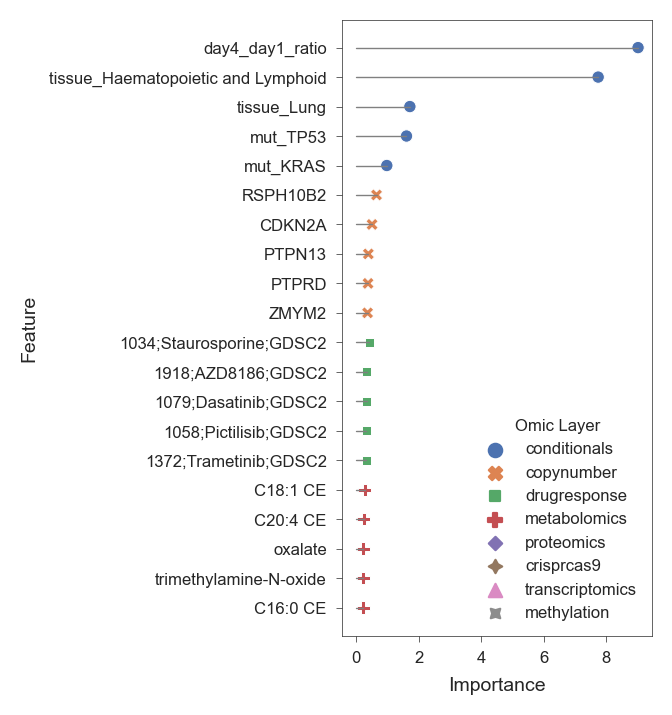

In [27]:
plt.figure(figsize=(2, 4))

# Create a categorical scatter plot and set marker style and size
g = sns.scatterplot(
    data=df_top5_part1,
    y="feature",
    x="importance",
    hue="omic_layer",
    palette=OMIC_PALLETS,
    style="omic_layer",
    s=20,
)

# Draw lines connecting each point to the y-axis
for _, row in df_top5_part1.iterrows():
    plt.plot([0, row["importance"]], [row["feature"], row["feature"]], "grey", lw=0.5)

# plt.title("Top 5 Features from Each Omic Layer by Importance")
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.legend(title="Omic Layer")
plt.show()

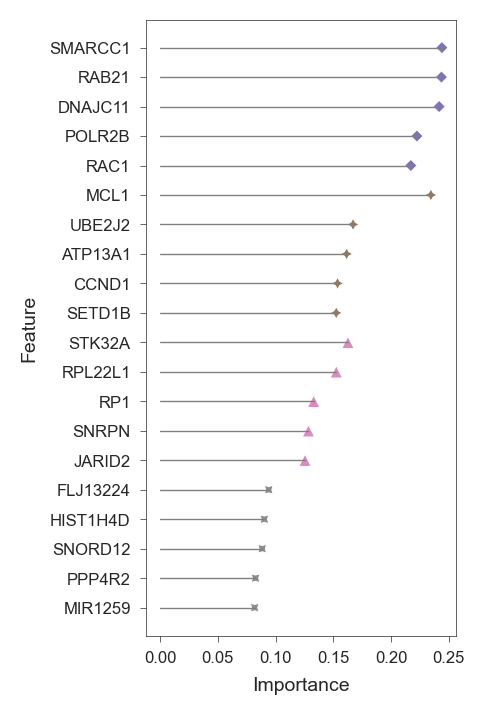

In [28]:
plt.figure(figsize=(2, 4))

# Create a categorical scatter plot and set marker style and size
sns.scatterplot(
    data=df_top5_part2,
    y="feature",
    x="importance",
    hue="omic_layer",
    style="omic_layer",
    s=20,
)

# Draw lines connecting each point to the y-axis
for _, row in df_top5_part2.iterrows():
    plt.plot([0, row["importance"]], [row["feature"], row["feature"]], "grey", lw=0.5)

# plt.title("Top 5 Features from Each Omic Layer by Importance")
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.legend(title="Omic Layer").remove()
plt.show()

# plot metabolomics 1-methylnicotinamide

In [18]:
def plot_feature_rank(feature, top=(0, 20)):
    plot_df = (
        shap_latent_sum_df.T[[feature]]
        .sort_values(by=feature, ascending=False)
        .head(20)
    )
    plot_df.index.name = "feature"
    plot_df["omic_layer"] = plot_df.index.map(lambda x: x.split("_")[0])
    plot_df["omic_layer"] = pd.Categorical(
        plot_df["omic_layer"],
        categories=marker_order,
        ordered=True,
    )
    plot_df = plot_df.reset_index()
    plot_df["feature"] = plot_df["feature"].map(lambda x: "_".join(x.split("_")[1:]))
    plot_df["feature"] = plot_df["feature"].map(lambda x: x.replace("tissue_", ""))
    plot_df["feature"] = plot_df["feature"].map(
        lambda x: f"{x.replace('mut_', '')} mutation" if x.startswith("mut_") else x
    )
    plot_df["feature"] = plot_df["feature"].map(
        lambda x: f"{x.split(';')[1]} ({x.split(';')[2]})" if "GDSC" in x else x
    )
    plt.figure(figsize=(1.5, 3))
    plot_df = plot_df.iloc[top[0] : top[1], :]

    # Create a categorical scatter plot and set marker style and size
    sns.scatterplot(
        data=plot_df,
        y="feature",
        x=feature,
        hue="omic_layer",
        palette=OMIC_PALLETS,
        style="omic_layer",
        s=20,
    )

    # Draw lines connecting each point to the y-axis
    for _, row in plot_df.iterrows():
        plt.plot([0, row[feature]], [row["feature"], row["feature"]], "grey", lw=0.5)

    plt.title(f"Top Features for {feature}", fontdict={"fontsize": 8})
    plt.ylabel("Feature")
    plt.xlabel("Importance")
    plt.legend(title="Omic Layer").remove()

In [19]:
marker_order = [
    "conditionals",
    "copynumber",
    "drugresponse",
    "metabolomics",
    "proteomics",
    "crisprcas9",
    "transcriptomics",
    "methylation",
]

In [23]:
feature = "metabolomics_1-methylnicotinamide"
plot_df = shap_latent_sum_df[[feature]]
plot_df["omic_layer"] = "drugresponse"
plot_df = plot_df.sort_values(by=feature, ascending=False).reset_index().head(20)
plot_df["omic_layer"] = pd.Categorical(
    plot_df["omic_layer"], categories=marker_order, ordered=True
)

In [31]:
shap_latent_sum_df[[feature]].head(50)

,metabolomics_1-methylnicotinamide
drug_name,
1001;AICA Ribonucleotide;GDSC1,0.164245
1003;Camptothecin;GDSC2,0.189696
1004;Vinblastine;GDSC1,0.131016
1004;Vinblastine;GDSC2,0.158694
1005;Cisplatin;GDSC1,0.304157
1005;Cisplatin;GDSC2,0.197098
1006;Cytarabine;GDSC1,0.174322
1006;Cytarabine;GDSC2,0.205751
1007;Docetaxel;GDSC1,0.235988


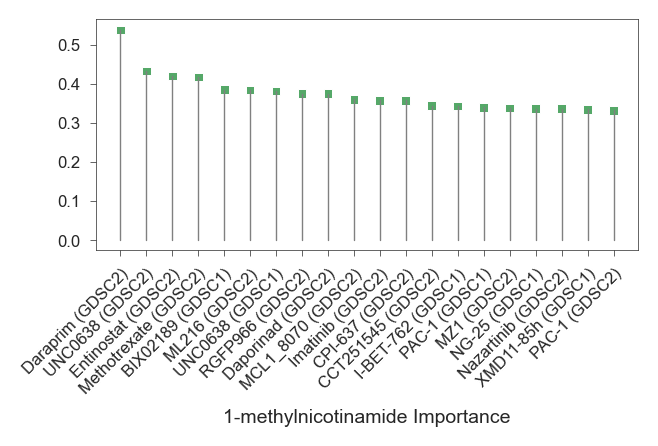

In [26]:
plt.figure(figsize=(3.5, 1.5))

# Create a categorical scatter plot and set marker style and size
ax1 = sns.scatterplot(
    data=plot_df,
    x="drug_name",
    y=feature,
    hue="omic_layer",
    palette=OMIC_PALLETS,
    style="omic_layer",
    s=20,
)

# Draw lines connecting each point to the y-axis
for _, row in plot_df.iterrows():
    plt.plot([row["drug_name"], row["drug_name"]], [0, row[feature]], "grey", lw=0.5)

tick_labels = plot_df["drug_name"].map(
    lambda x: f"{x.split(';')[1]} ({x.split(';')[2]})" if "GDSC" in x else x
)
ax1.set_xticklabels(tick_labels)

plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", size=6, rotation_mode="anchor")
plt.title(f"")
# plt.xlim(0.5, 0.9)
plt.ylabel("")
plt.xlabel("1-methylnicotinamide Importance")
plt.legend(title="Omic Layer").remove()
plt.savefig(
    f"./reports/vae/drugresponse/{TIMESTAMP}_1-methylnicotinamide_top10_h.pdf",
    bbox_inches="tight",
)

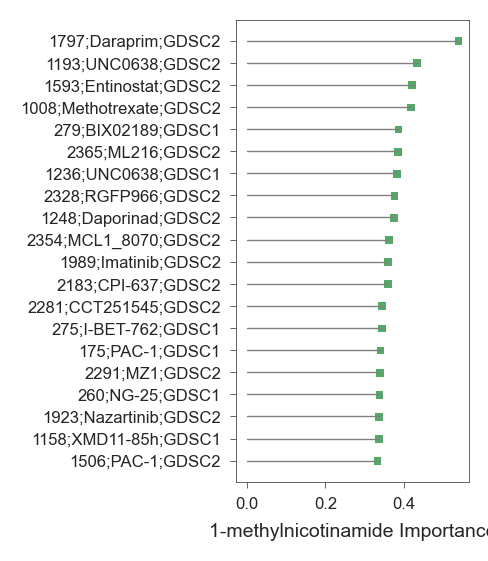

In [21]:
plt.figure(figsize=(1.5, 3))

# Create a categorical scatter plot and set marker style and size
sns.scatterplot(
    data=plot_df,
    y="drug_name",
    x=feature,
    hue="omic_layer",
    palette=OMIC_PALLETS,
    style="omic_layer",
    s=20,
)

# Draw lines connecting each point to the y-axis
for _, row in plot_df.iterrows():
    plt.plot([0, row[feature]], [row["drug_name"], row["drug_name"]], "grey", lw=0.5)

plt.title(f"")
# plt.xlim(0.5, 0.9)
plt.ylabel("")
plt.xlabel("1-methylnicotinamide Importance")
plt.legend(title="Omic Layer").remove()
plt.savefig(f"./reports/vae/drugresponse/{TIMESTAMP}_1-methylnicotinamide_top10.pdf")

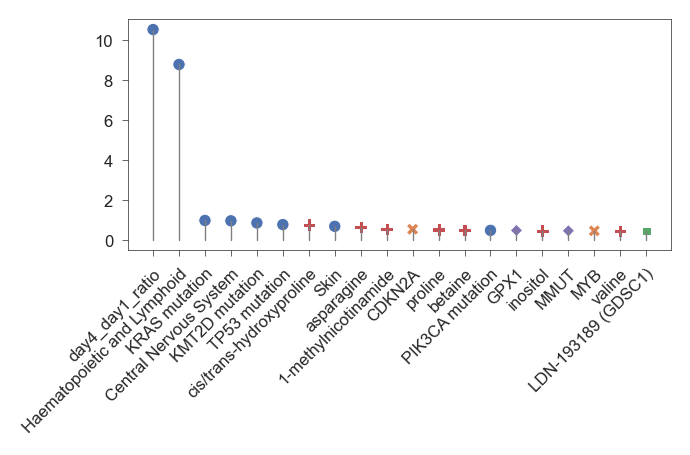

In [21]:
feature = plot_df["drug_name"].values[0]
feature_plot_df = (
    shap_latent_sum_df.T[[plot_df["drug_name"].values[0]]]
    .sort_values(by=feature, ascending=False)
    .head(20)
)
feature_plot_df.index.name = "feature"
feature_plot_df["omic_layer"] = feature_plot_df.index.map(lambda x: x.split("_")[0])
feature_plot_df["omic_layer"] = pd.Categorical(
    feature_plot_df["omic_layer"], categories=marker_order, ordered=True
)
feature_plot_df = feature_plot_df.reset_index()
feature_plot_df["feature"] = feature_plot_df["feature"].map(
    lambda x: "_".join(x.split("_")[1:])
)
feature_plot_df["feature"] = feature_plot_df["feature"].map(
    lambda x: f"{x.replace('mut_', '')} mutation" if x.startswith("mut_") else x
)
feature_plot_df["feature"] = feature_plot_df["feature"].map(
    lambda x: f"{x.split(';')[1]} ({x.split(';')[2]})" if "GDSC" in x else x
)
feature_plot_df["feature"] = feature_plot_df["feature"].map(
    lambda x: x.replace("tissue_", "")
)
feature_plot_df = feature_plot_df.iloc[:20, :]

plt.figure(figsize=(3.5, 1.5))

# Create a categorical scatter plot and set marker style and size
ax1 = sns.scatterplot(
    data=feature_plot_df,
    x="feature",
    y=feature,
    hue="omic_layer",
    palette=OMIC_PALLETS,
    style="omic_layer",
    s=20,
)

# Draw lines connecting each point to the y-axis
for _, row in feature_plot_df.iterrows():
    plt.plot([row["feature"], row["feature"]], [0, row[feature]], "grey", lw=0.5)

ax1.set_xticklabels(
    [x.split(";")[1] if ";" in x else x for x in feature_plot_df["feature"]]
)
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", size=6, rotation_mode="anchor")
plt.title(f"")
# plt.xlim(0.5, 0.9)
plt.ylabel("")
plt.xlabel("")
plt.legend(title="Omic Layer").remove()
plt.savefig(
    f"./reports/vae/drugresponse/{TIMESTAMP}_{feature}_top20_h.pdf",
    bbox_inches="tight",
)

In [ ]:
plot_df = (
    shap_latent_sum_df.T[[plot_df['drug_name'].values[0]]]
    .sort_values(by=feature, ascending=False)
    .head(20)
)
plot_df.index.name = "feature"
plot_df["omic_layer"] = plot_df.index.map(lambda x: x.split("_")[0])
plot_df["omic_layer"] = pd.Categorical(
    plot_df["omic_layer"], categories=marker_order, ordered=True
)
plot_df = plot_df.reset_index()
plot_df['feature'] = plot_df['feature'].map(lambda x: "_".join(x.split("_")[1:]))
plt.figure(figsize=(1.5, 3))
plot_df = plot_df.iloc[top[0] : top[1], :]

# Create a categorical scatter plot and set marker style and size
sns.scatterplot(
    data=plot_df,
    y="feature",
    x=feature,
    hue="omic_layer",
    palette=OMIC_PALLETS,
    style="omic_layer",
    s=20,
)

# Draw lines connecting each point to the y-axis
for _, row in plot_df.iterrows():
    plt.plot([0, row[feature]], [row["feature"], row["feature"]], "grey", lw=0.5)

plt.title(f"Top Features for {feature}", fontdict={"fontsize": 8})
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.legend(title="Omic Layer").remove()

In [13]:
plot_df

,drug_name,metabolomics_1-methylnicotinamide,omic_layer
0,1797;Daraprim;GDSC2,0.537715,drugresponse
1,1193;UNC0638;GDSC2,0.432501,drugresponse
2,1593;Entinostat;GDSC2,0.419759,drugresponse
3,1008;Methotrexate;GDSC2,0.417245,drugresponse
4,279;BIX02189;GDSC1,0.384785,drugresponse
5,2365;ML216;GDSC2,0.384018,drugresponse
6,1236;UNC0638;GDSC1,0.381660,drugresponse
7,2328;RGFP966;GDSC2,0.374583,drugresponse
8,1248;Daporinad;GDSC2,0.374152,drugresponse
9,2354;MCL1_8070;GDSC2,0.360423,drugresponse


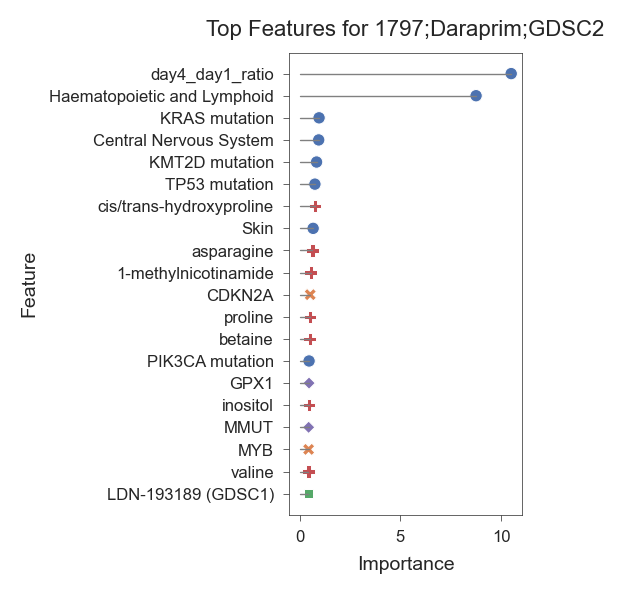

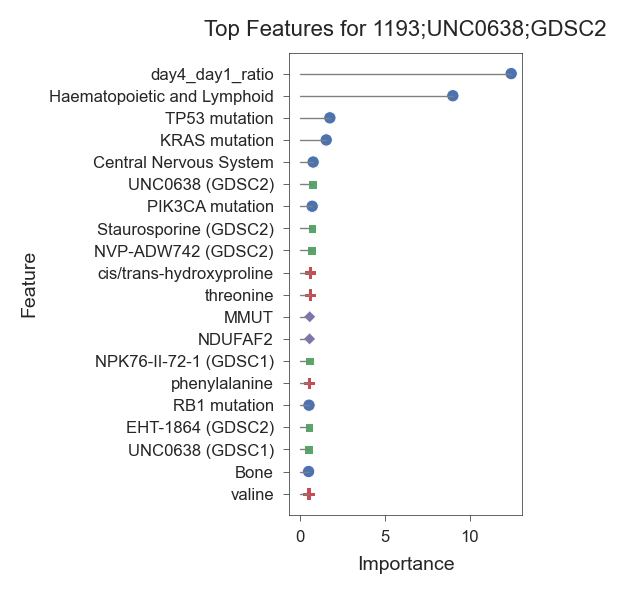

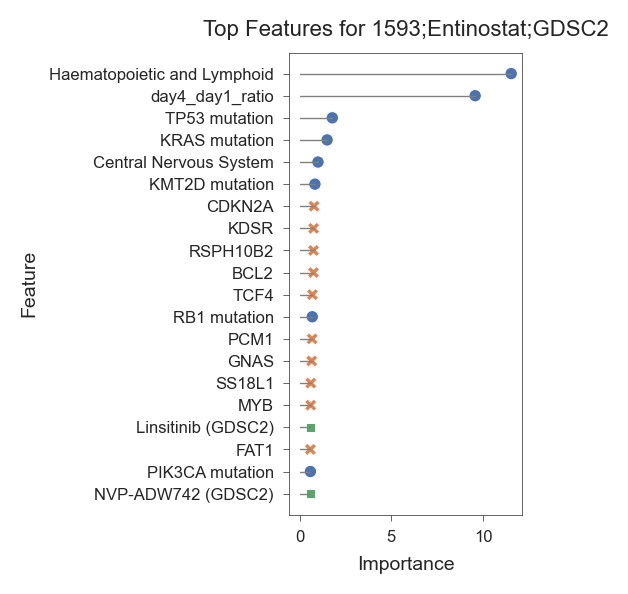

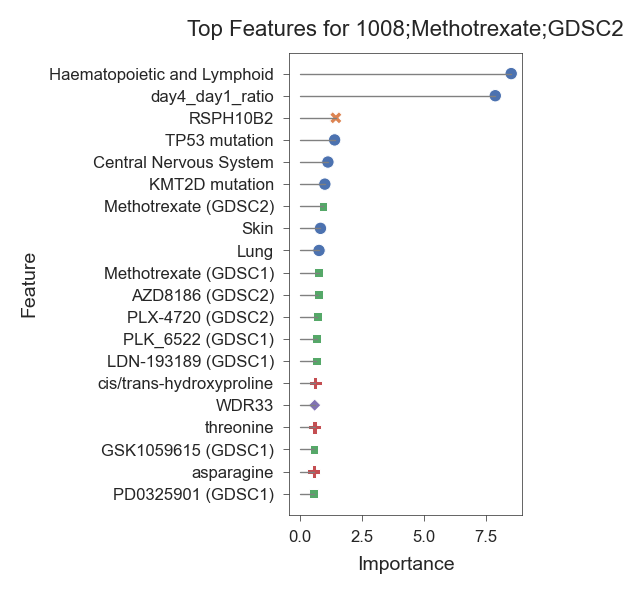

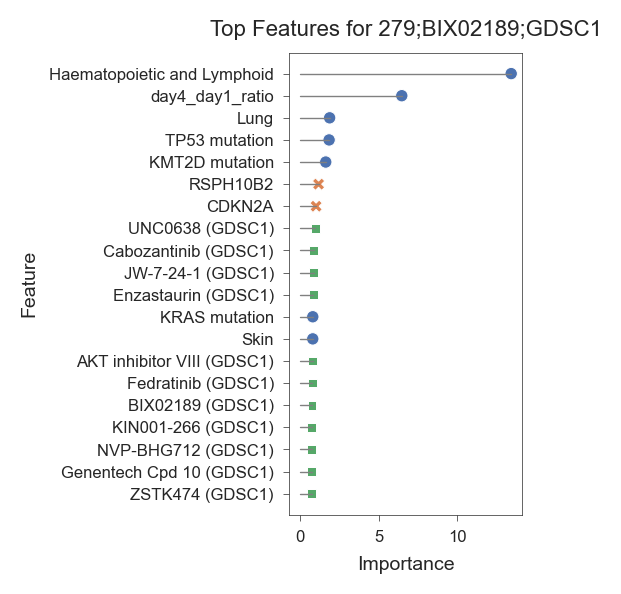

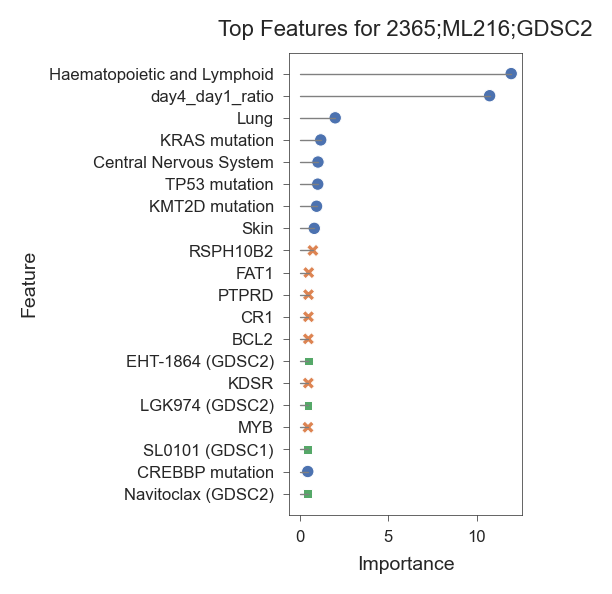

In [24]:
for feature in plot_df.head(6)["drug_name"].values:
    plot_feature_rank(feature, top=(0, 20))
    plt.savefig(
        f"./reports/vae/drugresponse/{TIMESTAMP}_{feature}_top20.pdf",
        bbox_inches="tight"
    )

In [35]:
feature = '1797;Daraprim;GDSC2'
plot_df = (
        shap_latent_sum_df.T[[feature]]
        .sort_values(by=feature, ascending=False)
    )
plot_df.index.name = "feature"
plot_df["omic_layer"] = plot_df.index.map(lambda x: x.split("_")[0])
plot_df["omic_layer"] = pd.Categorical(
    plot_df["omic_layer"], categories=marker_order, ordered=True
)
plot_df = plot_df.reset_index()
plot_df['feature'] = plot_df['feature'].map(lambda x: "_".join(x.split("_")[1:]))

In [36]:
plot_df

drug_name,feature,1797;Daraprim;GDSC2,omic_layer
0,day4_day1_ratio,10.500363,conditionals
1,tissue_Haematopoietic and Lymphoid,8.755131,conditionals
2,mut_KRAS,0.955388,conditionals
3,tissue_Central Nervous System,0.937008,conditionals
4,mut_KMT2D,0.831227,conditionals
...,...,...,...
27847,NUTM2B,0.000000,copynumber
27848,mut_MTOR,0.000000,conditionals
27849,mut_MYC,0.000000,conditionals
27850,MLLT11,0.000000,copynumber


In [37]:
plot_df[plot_df['feature'].isin(['GPX4', 'GPX1'])]

drug_name,feature,1797;Daraprim;GDSC2,omic_layer
14,GPX1,0.457230,proteomics
932,GPX4,0.168169,crisprcas9
11208,GPX1,0.049368,crisprcas9
19242,GPX4,0.025154,proteomics
21908,GPX1,0.019966,transcriptomics
27518,GPX1,0.006202,methylation


In [29]:
global_feature_importance_df.groupby("omic_layer")[["importance"]].mean().sort_values(
    "importance", ascending=False
)

,importance
omic_layer,
drugresponse,0.144201
conditionals,0.142618
metabolomics,0.107878
copynumber,0.088896
crisprcas9,0.065970
proteomics,0.063014
transcriptomics,0.052217
methylation,0.026857


In [14]:
global_feature_importance_omic_summary_df = (
    global_feature_importance_df.groupby("omic_layer")[["importance"]]
    .mean()
    .sort_values("importance", ascending=False)
).reset_index()

In [12]:
global_feature_importance_df

,feature,importance,omic_layer
0,conditionals_day4_day1_ratio,9.014879,conditionals
1,conditionals_tissue_Haematopoietic and Lymphoid,7.739065,conditionals
2,conditionals_tissue_Lung,1.715674,conditionals
3,conditionals_mut_TP53,1.607691,conditionals
4,conditionals_mut_KRAS,0.977371,conditionals
...,...,...,...
27847,copynumber_SETD1B,0.000000,copynumber
27848,copynumber_FOXD4L1,0.000000,copynumber
27849,conditionals_tissue_Adrenal Gland,0.000000,conditionals
27850,copynumber_ZNF814,0.000000,copynumber


In [12]:
global_feature_importance_omic_summary_df

,omic_layer,importance
0,drugresponse,0.144201
1,conditionals,0.142618
2,metabolomics,0.107878
3,copynumber,0.088896
4,crisprcas9,0.065970
5,proteomics,0.063014
6,transcriptomics,0.052217
7,methylation,0.026857


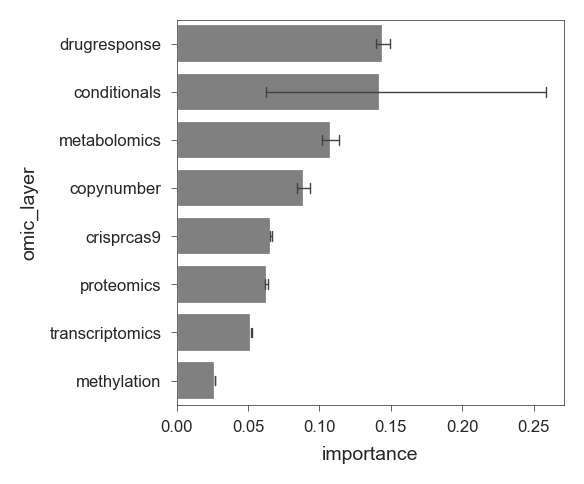

In [16]:
sns.barplot(
    x="importance",
    y="omic_layer",
    data=global_feature_importance_df,
    errwidth=0.5,
    ci=95,
    capsize=0.2,
    order=global_feature_importance_omic_summary_df["omic_layer"].tolist(),
    # palette=OMIC_PALLETS
    color="grey",
)
plt.savefig(
    f"./reports/vae/drugresponse/{TIMESTAMP}_drugresponse_shap_omic_ranking.pdf", bbox_inches="tight"
)